# Toronto Pcard expenditures Analysis

In [276]:
# Import libraries
import requests
from pathlib import Path
import sys
import os
import zipfile
import re
import pandas as pd
import numpy as np
from collections import Counter
from fuzzywuzzy import fuzz, process
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import seaborn as sb
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import HDBSCAN

In [2]:
# Global variables
ROOT_DIR = Path(__vsc_ipynb_file__).parent.parent

# Import utility functions from utils module
sys.path.append(str(ROOT_DIR/"src"))
from local_utils import fetch_data, preprocess_text

[nltk_data] Downloading package stopwords to /home/kubam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Fetch data
fetch_data(str(ROOT_DIR/"data"))

### Extract and Merge data from excel files

In [4]:
# Unzip data

url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/ebc3f9c2-2f80-4405-bf4f-5fb309581485/resource/d83a5249-fb07-4c38-9145-9e12a32ce1d4/download/pcard-expenses.zip'

local_file_path = str(ROOT_DIR / 'data' / 'raw' / 'expenditures.zip')
extracted_data_path = str(ROOT_DIR / 'data' / "extracted" )

if not os.path.exists(extracted_data_path):
    os.makedirs(extracted_data_path)
with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_data_path)

print(f" Data files successfully extracted ")
# Get all filenames and store in a list
file_list = [(filename, "".join(re.findall(r'\d+', filename))) for filename in os.listdir(extracted_data_path)]
file_list_sorted = sorted( file_list, key=lambda tup: tup[1])

# Check sheet names to make sure all files contain the same sheet names
sheet_details = [(pd.ExcelFile(os.path.join(extracted_data_path, tup[0])).sheet_names, tup[1], os.path.join(extracted_data_path, tup[0])) for tup in file_list_sorted ]

# Add number of sheets in each file
sheet_details = [(sheet_detail[0], len(sheet_detail[0]), sheet_detail[1], sheet_detail[2]) for sheet_detail in sheet_details]

 Data files successfully extracted 


In [5]:
# Check number of available months
print(
    pd.DataFrame(
        [[tup[2][:4], tup[2]] for tup in sheet_details], 
        columns=["year", "month"]).groupby("year")['month'].nunique()
    )

year
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019     7
Name: month, dtype: int64


In [6]:
sheet_details[:2]

[(['PCard Expenses_January 2011'],
  1,
  '201101',
  '/home/kubam/projects/toronto_pcard_expenditures/data/extracted/PCardExpenses_201101_Final.xls'),
 (['PCard Expenses_February 2011'],
  1,
  '201102',
  '/home/kubam/projects/toronto_pcard_expenditures/data/extracted/PCardExpenses_201102_Final.xls')]

In [7]:
# Excel files with more than 1 sheet
files_to_check = list(filter(lambda val: val[1] > 1, sheet_details))
files_to_check

[(['Sheet1', 'Sheet2', 'Sheet3'],
  3,
  '201203',
  '/home/kubam/projects/toronto_pcard_expenditures/data/extracted/PCardExpenses_201203_Final.xls'),
 (['2012_04 PCard Expenses', 'Sheet3'],
  2,
  '201204',
  '/home/kubam/projects/toronto_pcard_expenditures/data/extracted/PCardExpenses_201204_Final.xls')]

FYI: After manually checking files, I noticed data is only present in the first sheets which is in line with the rest of the files with only 1 sheet

In [8]:
# Read all excels to pandas dataframe
pcard_dfs = [pd.read_excel(sheet_info[3], sheet_name=0) for sheet_info in sheet_details]

In [9]:
# check shema ( columns ) for data quality issues
pcard_df_schemas = [list(df.columns) for df in pcard_dfs]

In [10]:
sample_data_schema = pcard_df_schemas[0]
print(sample_data_schema)

['Division', 'Batch-Transaction ID', 'Transaction Date', 'Card Posting Dt', 'Merchant Name', 'Transaction Amt.', 'Transaction Currency', 'Original Amount', 'Original Currency', 'G/L Account', 'G/L Account Description', 'Cost Centre / WBS Element', 'Cost Centre / WBS Element Description', 'Merchant Type', 'Merchant Type Description', 'Purpose']


In [11]:
# Get distinct column names
column_names = []
for schema in pcard_df_schemas:
    column_names += schema

all_column_names = set(column_names)

In [12]:
all_column_names

{' G/L Account Description',
 'Batch Transaction ID',
 'Batch-Transaction ID',
 'Card Posting Date',
 'Card Posting Dt',
 'Cost Center / WBLS Element / Order Description',
 'Cost Center / WBS Element / Order',
 'Cost Center / WBS Element / Order #',
 'Cost Center / WBS Element / Order # Description',
 'Cost Center / WBS Element / Order Description',
 'Cost Centre /  WBS Element',
 'Cost Centre /  WBS Element / Order No.',
 'Cost Centre /  WBS Element / Order No. Decription',
 'Cost Centre /  WBS Element Description',
 'Cost Centre / WBS\n Element',
 'Cost Centre / WBS Elelment',
 'Cost Centre / WBS Elelment Description',
 'Cost Centre / WBS Element',
 'Cost Centre / WBS Element ',
 'Cost Centre / WBS Element / Order',
 'Cost Centre / WBS Element / Order ',
 'Cost Centre / WBS Element / Order #',
 'Cost Centre / WBS Element / Order # Decription',
 'Cost Centre / WBS Element / Order # Description',
 'Cost Centre / WBS Element / Order Description',
 'Cost Centre / WBS Element / Order No',

In [13]:
col_mapping = {col_name: preprocess_text(col_name) for col_name in all_column_names}
clean_column_names = list(set(col_mapping.values()))
clean_column_names

['card posting dt',
 'trxcurrency',
 'transaction amt',
 'cost centrewbs elementwork order number description',
 'merchant name',
 'gl account',
 'transaction currency',
 'cost centre wbs element',
 'merchant type',
 'cost centre wbs elelment description',
 'purpose',
 'original currency1',
 'unnamed 17',
 'cost center wbs element order description',
 'cost centre wbs element order description',
 'cost centre wbs element descrption',
 'unnamed 16',
 'long text',
 'gl account discription',
 'tr currency',
 'gl account description',
 'original amount',
 'divison',
 'cost centrewbs element',
 'division',
 'cost center wbs element order',
 'merchant type description',
 'cost centre wbs element order',
 'exp type desc',
 'batch transaction id',
 'cost centre wbs element description',
 'cost centre wbs element order decription',
 'cost centre wbs elelment',
 'cost centre wbs element work order number',
 'cost centrewbs element description',
 'gl expense description',
 'transaction amount',
 

In [14]:
similar_cols = {}
match_found = []
for col_name in clean_column_names:
    match_res = process.extract(col_name, clean_column_names, scorer=fuzz.UWRatio)
    filtered_matches = [matched for matched, score in match_res if score > 90]
    if len(filtered_matches)>0:
        for matched_input in filtered_matches:
            if matched_input in match_found:
              continue
            else:
              similar_cols[matched_input] = sorted(filtered_matches, key=lambda val: len(val))[-1]

print(similar_cols)
       

# Manually override auto detection of similar columns for specific cases where model peformance was not good
similar_cols["transaction currency"] = "trx currency"

for key, val in similar_cols.items():
    if "cost" in val:
        if "description" in val:
            if "des" in key or "dis" in key or "dec" in key:
                similar_cols[key] = "cost center wbls element order description"
            else:
                similar_cols[key] = "cost center wbls element order"
        else:
            similar_cols[key] = "cost center wbls element order"

    if "gl" in val:
        if "de" in val or "di" in val:
            similar_cols[key] = "gl account description"
        else:
            similar_cols[key] = "gl account"

    if val == "exp type desc":
        similar_cols[key] = "gl account description"


    if val == "long text":
        similar_cols[key] = "gl account description"


similar_cols

{'card posting dt': 'card posting date', 'card posting date': 'card posting date', 'trxcurrency': 'trx currency', 'trx currency': 'trx currency', 'tr currency': 'trx currency', 'transaction amt': 'transaction amount', 'transaction amount': 'transaction amount', 'cost centrewbs elementwork order number description': 'cost centrewbs elementwork order number description', 'merchant name': 'merchant name', 'gl account': 'gl account', 'transaction currency': 'transaction currency', 'cost centre wbs element': 'cost centre wbs elelment', 'cost centrewbs element': 'cost centre wbs elelment', 'cost centre wbs elelment': 'cost centre wbs elelment', 'cost centre wbs element descrption': 'cost centre wbs elelment description', 'cost centre wbs element order': 'cost centre wbs element work order number', 'merchant type': 'merchant type mcc', 'merchant type mcc': 'merchant type mcc', 'cost centre wbs elelment description': 'cost centre wbs elelment description', 'cost centre wbs element description'

{'card posting dt': 'card posting date',
 'card posting date': 'card posting date',
 'trxcurrency': 'trx currency',
 'trx currency': 'trx currency',
 'tr currency': 'trx currency',
 'transaction amt': 'transaction amount',
 'transaction amount': 'transaction amount',
 'cost centrewbs elementwork order number description': 'cost center wbls element order description',
 'merchant name': 'merchant name',
 'gl account': 'gl account',
 'transaction currency': 'trx currency',
 'cost centre wbs element': 'cost center wbls element order',
 'cost centrewbs element': 'cost center wbls element order',
 'cost centre wbs elelment': 'cost center wbls element order',
 'cost centre wbs element descrption': 'cost center wbls element order description',
 'cost centre wbs element order': 'cost center wbls element order',
 'merchant type': 'merchant type mcc',
 'merchant type mcc': 'merchant type mcc',
 'cost centre wbs elelment description': 'cost center wbls element order description',
 'cost centre wbs

In [15]:
# Replace similar columns to valid column
modified_column_names = {}
for key, val in col_mapping.items():
    if similar_cols.get(val):
      modified_column_names[key] = re.sub(r'[^a-zA-Z0-9]', '_', similar_cols.get(val))

In [16]:
data_schema = list(set([ val for val in modified_column_names.values() if "unnamed" not in val]) )
data_schema

['gl_account',
 'merchant_type_mcc',
 'transaction_amount',
 'original_amount',
 'cost_center_wbls_element_order_description',
 'transaction_date',
 'merchant_name',
 'purpose',
 'gl_account_description',
 'merchant_type_description',
 'division',
 'batch_transaction_id',
 'cost_center_wbls_element_order',
 'original_currency1',
 'card_posting_date',
 'trx_currency']

In [17]:
# Rename dataframe columns
renamed_pcard_dfs = []
for ind, df in enumerate(pcard_dfs):
    orignal_cols = list(df.columns)
    mapped_cols = list(map(lambda val: modified_column_names[val], orignal_cols))
    if len(mapped_cols) > len(list(set(mapped_cols))):
        # Replace first instance of "originalcurrency" with "trxcurrency" in
        duplicates = [ind for ind, col in enumerate(mapped_cols) if col == "original_currency1"]
        if len(duplicates) > 1:
            mapped_cols[duplicates[0]] = "trx_currency"
            mod_df = df.rename(columns=modified_column_names)
            mod_df.columns = mapped_cols
            renamed_pcard_dfs.append(mod_df)
        else:
          renamed_pcard_dfs.append(df.rename(columns=modified_column_names))
    else:
      renamed_pcard_dfs.append(df.rename(columns=modified_column_names))


In [18]:
raw_df = pd.concat([data[data_schema] for data in renamed_pcard_dfs])

In [19]:
raw_df.head(2)

,gl_account,merchant_type_mcc,transaction_amount,original_amount,cost_center_wbls_element_order_description,transaction_date,merchant_name,purpose,gl_account_description,merchant_type_description,division,batch_transaction_id,cost_center_wbls_element_order,original_currency1,card_posting_date,trx_currency
0,2120,5085.0,34.99,34.99,WS SYSTEM CONTROL WO,2011-01-06,MOTION IND ON11,2310 (4L310) TRUFLEX BELT,PARTS - MACHINERY & EQUIPMENT,Industrial Supplies Not Elsewhere Classi,TORONTO WATER,1273-110,PW1020,CAD,2011-01-10,CAD
1,2120,1520.0,208.37,208.37,WS SYSTEM CONTROL WO,2011-01-11,KOTYCK BROS LIMITED,NaN,PARTS - MACHINERY & EQUIPMENT,General Contractors - Residential and Co,TORONTO WATER,1277-138,PW1020,CAD,2011-01-12,CAD


In [20]:
# Create copy of raw data to use for further analysis
raw_df_copy = raw_df.copy()

In [21]:
size = raw_df.shape
print(f"Raw Dataset contains {size[0]} rows and {size[1]} columns")

Raw Dataset contains 493133 rows and 16 columns


In [22]:
# View data columns
raw_df_copy.columns

Index(['gl_account', 'merchant_type_mcc', 'transaction_amount',
       'original_amount', 'cost_center_wbls_element_order_description',
       'transaction_date', 'merchant_name', 'purpose',
       'gl_account_description', 'merchant_type_description', 'division',
       'batch_transaction_id', 'cost_center_wbls_element_order',
       'original_currency1', 'card_posting_date', 'trx_currency'],
      dtype='object')

### Scope data
Keep only transactions with valid:
- full year expenses ( 2011 to 2018)
- batch_transaction_id
- transaction_date
- positive transaction_amount and 
- division

In [23]:
# Remove all transactions without an id
start_date = "2011-01-01"
end_date = "2018-12-31"
scoped_df = raw_df_copy.query("batch_transaction_id.notnull() and division.notnull() and transaction_date.notnull() and transaction_amount > 0 and @start_date <= transaction_date <= @end_date ")

filtered_df = scoped_df.copy()

### Data wrangling
- Improve data quality
- create new features

In [24]:
# clean divisions
divisions = filtered_df.division.unique()

# Distinct Divisions before cleaning
print(f"Number of distinct division before cleaning: {len(divisions)}")

divisions_mapping = {division: preprocess_text(division)  for division in divisions}
divisions_reverse_mapping = {transformed: original for original, transformed in divisions_mapping.items()}

filtered_df = filtered_df.assign(
    division = lambda df: df.division.apply(lambda val: divisions_mapping[val])
)

pre_process_divisions = list(set(divisions_mapping.values()))
matched = []
similar_divisions = {}
for input_division in pre_process_divisions:
    if input_division in matched:
        continue
    match_res = process.extract(input_division, pre_process_divisions, scorer=fuzz.UWRatio)
    matches = [matched for matched, score in match_res if score > 90]
    if len(matches)>0:
      matched = matches + matched
      for matched_string in matches:
          similar_divisions[matched_string] = sorted(matches, key=lambda val: len(val))[-1]

filtered_df = filtered_df.assign(
    division = lambda df: df.division.apply(lambda val: similar_divisions.get(val))
)

filtered_df = filtered_df.assign(
    division = lambda df: df.division.apply(lambda val: divisions_reverse_mapping.get(val))
)

# Distinct Divisions after cleaning
print(f"Number of distinct divisions after cleaning: {filtered_df.division.nunique()}")

Number of distinct division before cleaning: 102
Number of distinct divisions after cleaning: 66


In [25]:
# Create copy of filtered data for feature engineering
feature_eng_df = filtered_df.copy()
feature_eng_df.columns

Index(['gl_account', 'merchant_type_mcc', 'transaction_amount',
       'original_amount', 'cost_center_wbls_element_order_description',
       'transaction_date', 'merchant_name', 'purpose',
       'gl_account_description', 'merchant_type_description', 'division',
       'batch_transaction_id', 'cost_center_wbls_element_order',
       'original_currency1', 'card_posting_date', 'trx_currency'],
      dtype='object')

In [26]:
feature_eng_df.describe()

,merchant_type_mcc,transaction_amount,original_amount
count,370778.000000,370786.000000,370786.000000
mean,5953.480730,245.636965,248.492963
std,1485.281999,655.677282,936.593088
min,0.000000,0.010000,0.010000
25%,5200.000000,29.920000,29.790000
50%,5411.000000,80.000000,79.940000
75%,5970.000000,226.580000,226.000000
max,9402.000000,61842.370000,172272.000000


In [61]:
# sort data
feature_eng_df = feature_eng_df.sort_values(by=['division', 'transaction_date'], ascending=False,  inplace=False)

feature_eng_df = feature_eng_df.assign(
    transaction_date = lambda df: pd.to_datetime(df['transaction_date']),
    card_posting_date = lambda df: pd.to_datetime(df['card_posting_date']),
    transaction_gt_50 = lambda df: np.where(df['transaction_amount'] > 100, True, False), 
    merchant_name = lambda df: df['merchant_name'].apply(preprocess_text),
)

feature_eng_df = feature_eng_df.assign(
    transaction_day_of_week = lambda df: df['transaction_date'].dt.dayofweek,
    transaction_month = lambda df: df['transaction_date'].dt.strftime('%Y%m'), 
    transaction_year = lambda df: df['transaction_date'].dt.year
)

feature_eng_df = feature_eng_df.assign(
    weekday_transaction = lambda df: np.where(df['transaction_day_of_week'] < 5, True, False),
    transaction_to_original_diff = lambda df:  np.where(df['transaction_amount'] / df['original_amount'] != 1, True, False),
    currency_change = lambda df: np.where(df['trx_currency'] != df['original_currency1'], True, False)
)


# Calculate time differences within each group
feature_eng_df = feature_eng_df.assign(transaction_freq_gt_weekly = lambda df: np.where(df.groupby('division')['transaction_date'].diff().dt.days/7>1, True, False))

In [62]:
feature_eng_df.head()

,gl_account,merchant_type_mcc,transaction_amount,original_amount,cost_center_wbls_element_order_description,transaction_date,merchant_name,purpose,gl_account_description,merchant_type_description,...,card_posting_date,trx_currency,transaction_gt_50,transaction_day_of_week,transaction_month,transaction_year,weekday_transaction,transaction_to_original_diff,currency_change,transaction_freq_gt_weekly
1003,2020.0,5399.0,60.85,60.85,HEAD OFF-POLICY&RESR,2011-06-26,indigo books music,Book: Canadian Urban Regions,BOOK & MAGAZINE SUBSCRIPTIONS,Miscellaneous General Merchandise,...,2011-06-27,CAD,False,6,201106,2011,False,False,False,False
1002,2020.0,7338.0,273.45,273.45,HEAD OFF-POLICY&RESR,2011-06-07,carswell,update#4 to looseleaf publication:Planning&Zoning,BOOK & MAGAZINE SUBSCRIPTIONS,"Quick Copy, Reproduction, and Blueprinti",...,2011-06-08,CAD,True,1,201106,2011,True,False,False,False
895,2020.0,7338.0,281.85,281.85,HEAD OFF-POLICY&RESR,2011-05-20,carswell,LooseLeaf Publications updates,BOOK & MAGAZINE SUBSCRIPTIONS,"Quick Copy, Reproduction, and Blueprinti",...,2011-05-24,CAD,True,4,201105,2011,True,False,False,False
896,2020.0,5942.0,91.30,91.30,HEAD OFF-POLICY&RESR,2011-05-20,rei lexisnexis canada,update to looseleaf publication inv#10288391,BOOK & MAGAZINE SUBSCRIPTIONS,Book Stores,...,2011-05-24,CAD,False,4,201105,2011,True,False,False,False
894,2020.0,7829.0,45.82,45.99,HEAD OFF-POLICY&RESR,2011-05-14,createspace,Book: Rapid Graphs with Tableau Software 6,BOOK & MAGAZINE SUBSCRIPTIONS,Motion Picture and Video Tape Production,...,2011-05-16,CAD,False,5,201105,2011,False,True,True,False


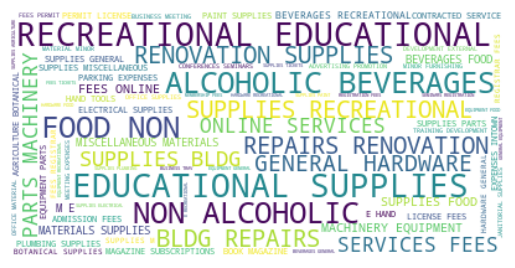

In [48]:
# Create word cloud to visualize expense types
expense_types = " ".join(expense_type for expense_type in feature_eng_df.gl_account_description)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(expense_types)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Create Division features

In [223]:
division_df = feature_eng_df.copy()

# Feature: total transactions
division_df = division_df.groupby(["division", 'transaction_year']).agg({
    'transaction_amount': ["sum", "mean", "std"],
    'batch_transaction_id': "count",
    'weekday_transaction': "sum",
    'transaction_to_original_diff': "sum",
    'currency_change': "sum",
    'cost_center_wbls_element_order': 'count', 
    'merchant_name': 'count',
    'gl_account': 'count', 
    'transaction_gt_50': 'count',
    'transaction_freq_gt_weekly': 'count'
}).reset_index()

division_df.columns = [
    "division", "transaction_year",
    "total_transaction_amount", "mean_transaction_amount", "spread_in_transaction_amount",
    "total_transactions", "total_weekday_transactions", 
    "total_transactions_with_dff_origin_trans","total_transactions_with_currency_change", 
    "total_cost_centers", "number_of_merchants", "total_expense_types", 'total_transactions_gt_50',
    "total_trans_gt_weekly"
]

# Derived Features
division_df = division_df.assign(
    ratio_transactions_gt_weekly=lambda df: df['total_trans_gt_weekly']/df['total_transactions'],
    ratio_transactions_gt_50=lambda df: df['total_transactions_gt_50']/df['total_transactions'],
    ratio_transactions_with_currency_change=lambda df: df['total_transactions_with_currency_change']/df['total_transactions'],
    ratio_weekday_transactions=lambda df: df['total_weekday_transactions']/df['total_transactions'],
    ratio_off_origin_trans_transactions=lambda df: df['total_transactions_with_dff_origin_trans']/df['total_transactions'],
    ratio_cost_center_merchant=lambda df: df['total_cost_centers']/df['number_of_merchants'],
    ratio_cost_center_expense_types=lambda df: df['total_cost_centers']/df['total_expense_types'],
    ratio_merchant_expense_types=lambda df: df['number_of_merchants']/df['total_expense_types'],
)

# Pivot dataframe to create new features from transaction year
ind_col = "division"
pivot_col = "transaction_year"
value_cols = list(set(division_df.columns) - set([ind_col, pivot_col]))

division_pivoted_df = division_df.pivot(index=ind_col, columns=pivot_col, values=value_cols)
division_pivoted_df.columns = [f'{col[0]}_{col[1]}' for col in division_pivoted_df.columns]
division_pivoted_df = division_pivoted_df.reset_index()

def first_and_last_non_zero_value(lst):
    first = None
    last = None
    for value in lst:
        if value is not None:
            first = value
            break
    for value in reversed(lst):
        if value is not None:
            last = value
            break

    return [first, last]

def compute_evolutive_figures(data_row, colum_type):
    filtered_keys = data_row.keys()
    print(filtered_keys)
    val_list = [elm for elm in data_row is ]

# Add evolutive metrics
division_pivoted_df = division_pivoted_df.assign(
    evol_mean_trans_amount=lambda df: df.apply(lambda row: min[], axis=1)
)



In [224]:
division_pivoted_df.columns

Index(['division', 'ratio_cost_center_merchant_2011',
       'ratio_cost_center_merchant_2012', 'ratio_cost_center_merchant_2013',
       'ratio_cost_center_merchant_2014', 'ratio_cost_center_merchant_2015',
       'ratio_cost_center_merchant_2016', 'ratio_cost_center_merchant_2017',
       'ratio_cost_center_merchant_2018',
       'ratio_cost_center_expense_types_2011',
       ...
       'total_expense_types_2017', 'total_expense_types_2018',
       'ratio_merchant_expense_types_2011',
       'ratio_merchant_expense_types_2012',
       'ratio_merchant_expense_types_2013',
       'ratio_merchant_expense_types_2014',
       'ratio_merchant_expense_types_2015',
       'ratio_merchant_expense_types_2016',
       'ratio_merchant_expense_types_2017',
       'ratio_merchant_expense_types_2018'],
      dtype='object', length=161)

### Visualization Dataset

In [51]:
viz_df = feature_eng_df.copy()

total_expenses = viz_df['batch_transaction_id'].count()
division_expenses = viz_df.groupby('division')['batch_transaction_id'].count()
perc_expense = division_expenses*100 / total_expenses
perc_expense_df = pd.DataFrame({'division': perc_expense.index, 'percentage': perc_expense.values})

expense_df = perc_expense_df.sort_values(by="percentage", ascending=False).assign(
    cumulative_perc = lambda df: df.percentage.cumsum().round(2)
).reset_index(drop=True )

print(expense_df.head(5))

top_divisions = expense_df.query("cumulative_perc <= 80")['division'].values

print(top_divisions)

# Rename less representative divisions to "OTHER"

viz_df = viz_df.assign(
    division=lambda df: df['division'].apply(lambda val: val if val in top_divisions else "OTHER")
)


viz_df = viz_df.groupby(['division', 'transaction_year']).agg({
    'transaction_amount': ["sum", "mean", "std"],
    'batch_transaction_id': "count",
    'weekday_transaction': "sum",
    'transaction_to_original_diff': "sum",
    'currency_change': "sum",
    'cost_center_wbls_element_order': 'count', 
    'merchant_name': 'count',
    'gl_account': 'count', 
    'transaction_gt_50': 'count'
})
viz_df.columns = [
    "total_transaction_amount", "mean_transaction_amount", "spread_in_transaction_amount",
    "total_transactions", "total_weekday_transactions", 
    "total_transactions_with_dff_origin_trans","total_transactions_with_currency_change", 
    "total_cost_centers", "number_of_merchants", "total_expense_types", 'total_transactions_gt_50'
]

viz_df = viz_df.assign(
    perc_transactions_gt_50=lambda df: df['total_transactions_gt_50']*100/df['total_transactions'],
    perc_transactions_with_currency_change=lambda df: df['total_transactions_with_currency_change']*100/df['total_transactions'],
    perc_weekday_transactions=lambda df: df['total_weekday_transactions']*100/df['total_transactions'],
    perc_off_origin_trans_transactions=lambda df: df['total_transactions_with_dff_origin_trans']*100/df['total_transactions'],
    ratio_cost_center_merchant=lambda df: df['total_cost_centers']/df['number_of_merchants'],
    ratio_cost_center_expense_types=lambda df: df['total_cost_centers']/df['total_expense_types'],
    ratio_merchant_expense_types=lambda df: df['number_of_merchants']/df['total_expense_types'],
)

                         division  percentage  cumulative_perc
0   PARKS, FORESTRY & RECREATION    54.177882            54.18
1  ECONOMIC DEVELOPMENT & CULTURE    7.847384            62.03
2                   TORONTO WATER    7.053664            69.08
3                  LEGAL SERVICES    5.594062            74.67
4   FACILITIES MANAGEMENT DIVISON    4.937080            79.61
['PARKS, FORESTRY & RECREATION ' 'ECONOMIC DEVELOPMENT & CULTURE'
 'TORONTO WATER' 'LEGAL SERVICES' 'FACILITIES MANAGEMENT DIVISON']


### Visualize data

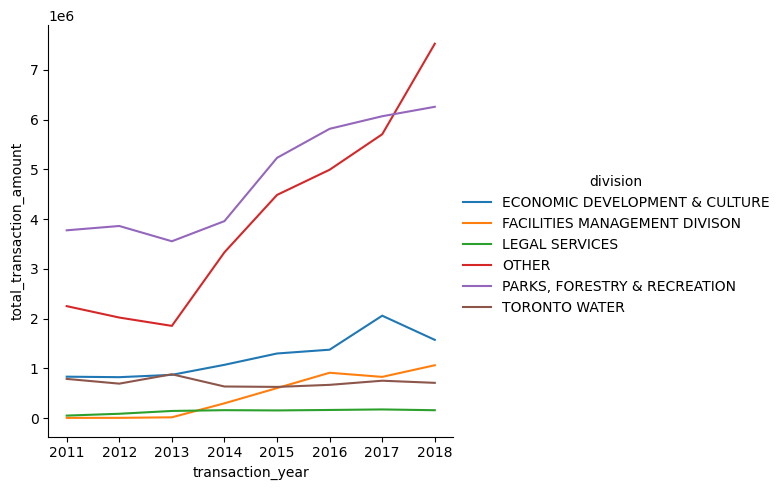

In [52]:
# Transaction amount
sb.relplot(data=viz_df, x="transaction_year", y="total_transaction_amount", kind="line", errorbar=None, hue="division", legend="auto")

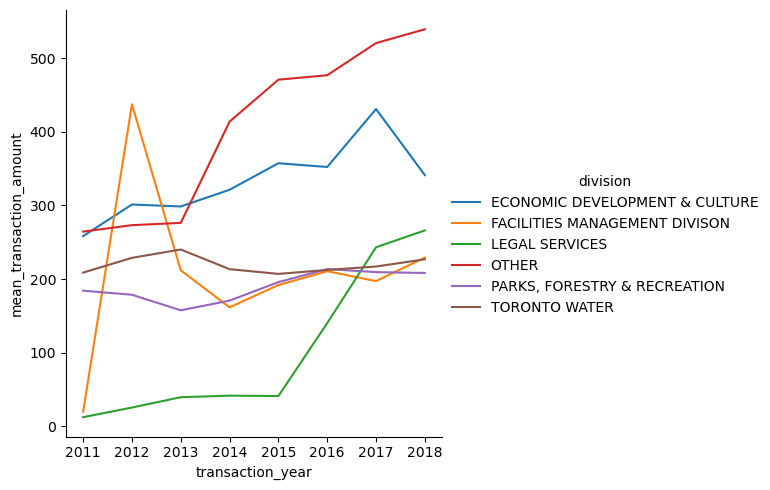

In [200]:
# Mean transaction amount
sb.relplot(data=viz_df, x="transaction_year", y="mean_transaction_amount", kind="line", errorbar=None, hue="division", legend="auto")

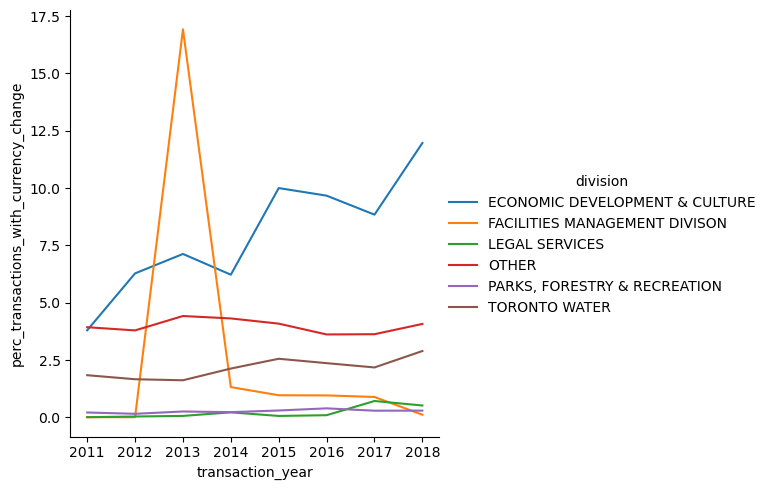

In [53]:
# Ratio of transactions involving change in currency
sb.relplot(data=viz_df, x="transaction_year", y="perc_transactions_with_currency_change", kind="line", errorbar=None, hue="division", legend="auto")

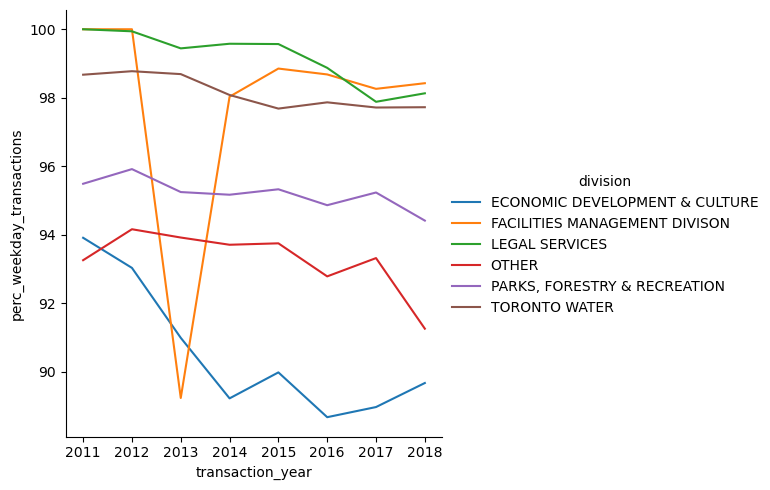

In [54]:
# Ratio of weekday transactions
sb.relplot(data=viz_df, x="transaction_year", y="perc_weekday_transactions", kind="line", errorbar=None, hue="division", legend="auto")

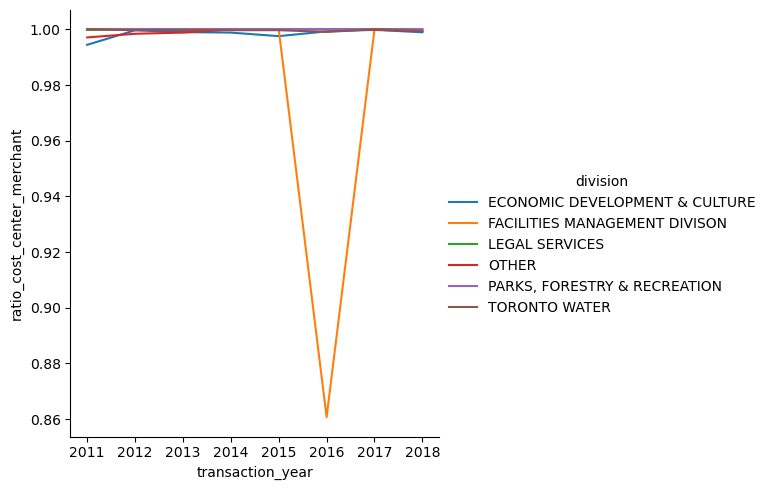

In [56]:
# cost center to merchant ratio 
sb.relplot(data=viz_df, x="transaction_year", y="ratio_cost_center_merchant", kind="line", errorbar=None, hue="division", legend="auto")

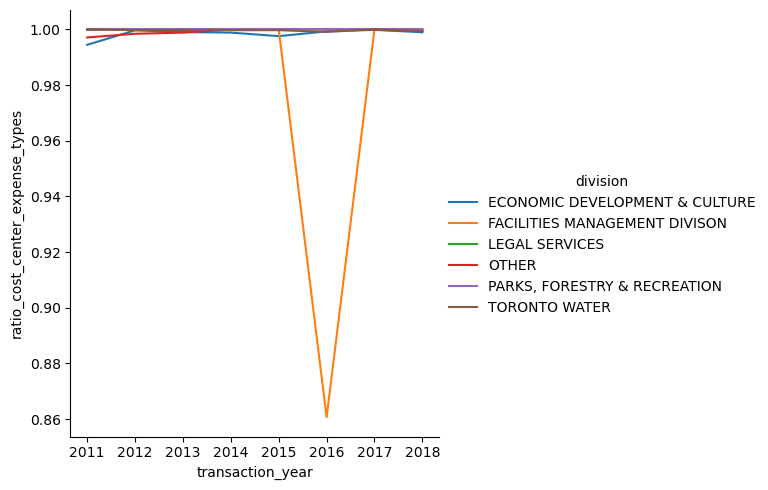

In [57]:
# cost center to expense type 
sb.relplot(data=viz_df, x="transaction_year", y="ratio_cost_center_expense_types", kind="line", errorbar=None, hue="division", legend="auto")

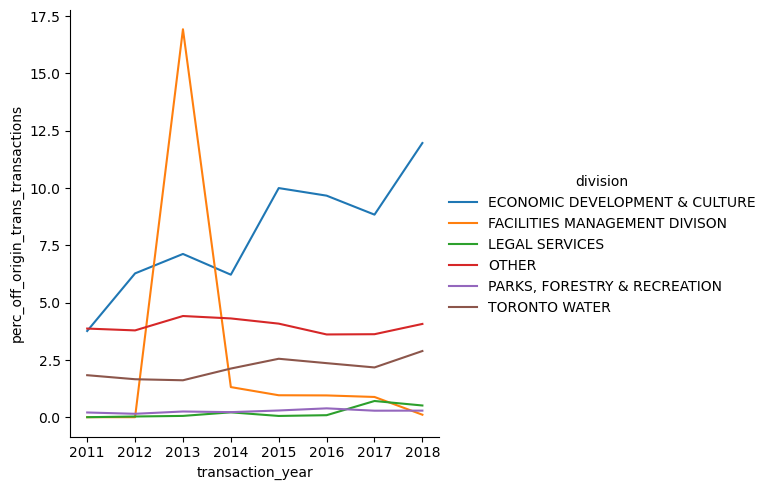

In [108]:
# Ratio Merchant expense type
sb.relplot(data=viz_df, x="transaction_year", y="perc_off_origin_trans_transactions", kind="line", errorbar=None, hue="division", legend="auto")

### Clustering


In [331]:
cluster_df = division_pivoted_df.copy()

value_cols = list(set(cluster_df.columns)-set(["division"]))

# Impute column means for missing values
cluster_df = cluster_df.fillna(cluster_df.mean())

no_vars = 7

# Selecting top 'no_vars' variables with highest variance 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df[value_cols])

pca = PCA()
pca.fit(scaled_data)

# Get explained variance ratios and cumulative explained variance
explained_variance_ratios = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Sort variables by decreasing explained variance ratio
sorted_variances_indices = np.argsort(explained_variance_ratios)[::-1]

# top variance variables
top_var_variables = cluster_df[value_cols].columns[sorted_variances_indices[:no_vars]]

print(top_var_variables)


Index(['ratio_cost_center_merchant_2017', 'spread_in_transaction_amount_2011',
       'number_of_merchants_2011', 'total_transactions_2012',
       'total_cost_centers_2012', 'ratio_transactions_gt_weekly_2012',
       'ratio_cost_center_merchant_2015'],
      dtype='object')


/tmp/ipykernel_20503/614323141.py:6: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  cluster_df = cluster_df.fillna(cluster_df.mean())


/home/kubam/projects/toronto_pcard_expenditures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kubam/projects/toronto_pcard_expenditures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kubam/projects/toronto_pcard_expenditures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/kubam/projects/toronto_pcard_expenditures/venv/lib/p

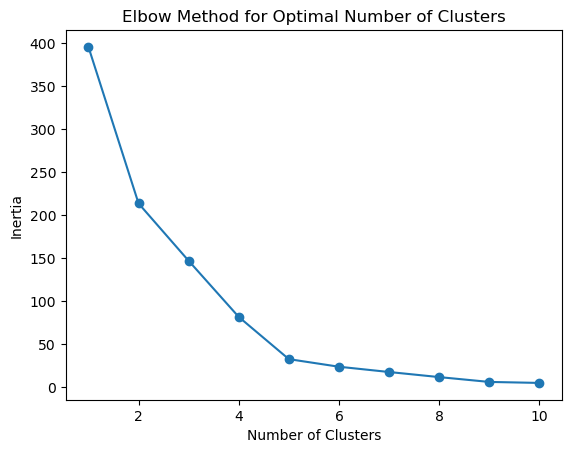

In [332]:
# Creating new dataframe for clustering

df = cluster_df[top_var_variables]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply K-Means clustering with different numbers of clusters
inertia_values = []
for n_clusters in range(1, 11):  
    kmeans = KMeans(n_clusters=n_clusters, random_state=1001)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)


# Plot the Elbow curve
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

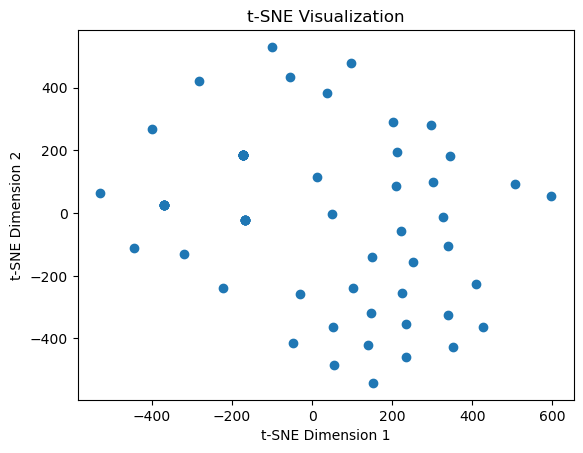

In [333]:
# visualize data using t-SNE
tsne = TSNE(n_components=2, random_state=1001)

# Fit and transform the data using t-SNE
tsne_data = tsne.fit_transform(scaled_data)

# Create a scatter plot to visualize the t-SNE results
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

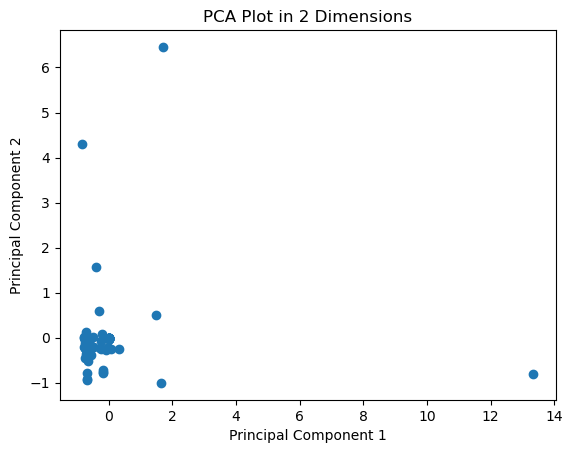

In [334]:
# Perform PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot the PCA results in 2D
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot in 2 Dimensions')
plt.show()

/home/kubam/projects/toronto_pcard_expenditures/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,division,ratio_cost_center_merchant_2011,ratio_cost_center_merchant_2012,ratio_cost_center_merchant_2013,ratio_cost_center_merchant_2014,ratio_cost_center_merchant_2015,ratio_cost_center_merchant_2016,ratio_cost_center_merchant_2017,ratio_cost_center_merchant_2018,ratio_cost_center_expense_types_2011,...,ratio_merchant_expense_types_2012,ratio_merchant_expense_types_2013,ratio_merchant_expense_types_2014,ratio_merchant_expense_types_2015,ratio_merchant_expense_types_2016,ratio_merchant_expense_types_2017,ratio_merchant_expense_types_2018,cluster,distance_to_cluster_center,anomaly
0,311 TORONTO,1.000000,1.000000,1.000000,1.000000,0.999922,0.996472,1.00000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.683094,False
1,ACCOUNTING SERVICES,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.540885,False
2,AFFORDABLE HOUSING OFFICE,0.998852,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.998852,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.488480,False
3,AfFFORDABLE HOUSING OFFICE,1.000000,1.000000,0.999515,0.999912,0.999922,0.996472,0.99995,0.999315,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.778847,False
4,CFO,0.998852,0.999731,0.999515,0.999912,0.999922,0.996472,1.00000,1.000000,0.998852,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.322190,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,TORONTO WATER,1.000000,0.999669,0.999727,0.999663,0.999669,0.999044,1.00000,0.999359,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.950940,False
62,TRANSPORTATION,1.000000,0.999731,0.999515,0.999912,0.999922,0.996472,0.99995,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.343261,False
63,TRANSPORTATION SERVICES,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.474130,False
64,TREASURER,0.998852,0.999731,0.999515,0.999912,0.999922,0.996472,1.00000,1.000000,0.998852,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0.322190,False


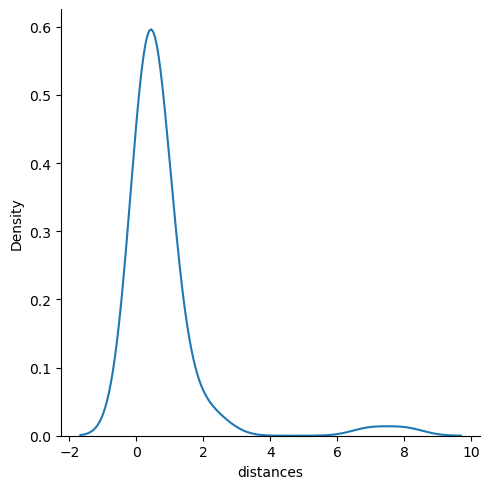

In [335]:
# K means clustering

n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit the data and predict clusters
cluster_df['cluster'] = kmeans.fit_predict(scaled_data)

cluster_label = cluster_df['cluster']

# cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculate Euclidean distances from data points to cluster centers
division_distances = np.linalg.norm(scaled_data - cluster_centers[cluster_df['cluster']], axis=1)

# plot division distances
sb.displot(pd.DataFrame(division_distances, columns=['distances']), x="distances", kind="kde")

# Set a threshold for anomaly detection
anomaly_threshold = 2.5

cluster_df['distance_to_cluster_center'] = division_distances

# Identify anomalies based on the threshold
cluster_df['anomaly'] = division_distances > anomaly_threshold

cluster_df

In [336]:
# Get cluster characteristics
cluster_df[list(top_var_variables)+['cluster']].groupby('cluster').describe()

ratio_cost_center_merchant_2017                                \
                                  count      mean       std       min   
cluster                                                                 
0                                  64.0  0.999951  0.000256  0.997947   
1                                   1.0  1.000000       NaN  1.000000   
2                                   1.0  0.999791       NaN  0.999791   

                                                 \
              25%       50%       75%       max   
cluster                                           
0        0.999950  1.000000  1.000000  1.000000   
1        1.000000  1.000000  1.000000  1.000000   
2        0.999791  0.999791  0.999791  0.999791   

        spread_in_transaction_amount_2011              ...  \
                                    count        mean  ...   
cluster                                                ...   
0                                    64.0  406.661020  ...   
1                                     1.0  244.569645  ...   
2                                     1.0  642.011315  ...   

        ratio_transactions_gt_weekly_2012       \
                                      75%  max   
cluster                                          
0                                     1.0  1.0   
1                                     1.0  1.0   
2                                     1.0  1.0   

        ratio_cost_center_merchant_2015                                \
                                  count      mean       std       min   
cluster                                                                 
0                                  64.0  0.999958  0.000054  0.999669   
1                                   1.0  1.000000       NaN  1.000000   
2                                   1.0  0.997522       NaN  0.997522   

                                                 
              25%       50%       75%       max  
cluster                                          
0        0.999922  1.000000  1.000000  1.000000  
1        1.000000  1.000000  1.000000  1.000000  
2        0.997522  0.997522  0.997522  0.997522  

[3 rows x 56 columns]

In [337]:
# Top 10 divisions by abnormality
abnormal_div_df = cluster_df.sort_values(by=['distance_to_cluster_center'], ascending=False)
abnormal_div_df[['division']].head(10)

,division
53,SOLID WASTE MANAGEMENT
51,SHELTER & SUPPORTIVE HOUSING ADMINISTRATION
27,FINANCIAL SERVICES
33,LEGAL SERVICES
61,TORONTO WATER
25,FINANCE & ADMINISTRATION
24,FACILITIES MANAGEMENT DIVISON
54,STRATEGIC & CORPORATE POLICY
31,INFORMATION & TECHNOLOGY
49,REAL ESTATE SERVICES


In [338]:
# DBSCAN


# define the model
dbscan_model = HDBSCAN(min_cluster_size=5, cluster_selection_method="leaf")

# fit model
dbscan_model.fit(df)

cluster_prob = dbscan_model.probabilities_

div_cluster = dbscan_model.labels_

# get all of the unique clusters
dbscan_clusters = np.unique(div_cluster)


#db cluster characteristics
dbscan_df = division_pivoted_df.copy()
dbscan_df["cluster"] = div_cluster
dbscan_df["cluster_prob"] = cluster_prob

In [339]:
# Sort divisions by cluster prob ascending
print(dbscan_df.sort_values(by="cluster_prob", ascending=True)[['division']].head(10))

# characteristics of clusters
dbscan_df.groupby(["cluster"])[list(top_var_variables)].agg(["mean"])

                                       division
19                   EMERGENCY MEDICAL SERVICES
46                                         PPFA
18               ECONOMIC DEVELOPMENT & CULTURE
51  SHELTER & SUPPORTIVE HOUSING ADMINISTRATION
27                           FINANCIAL SERVICES
28                                FIRE SERVICES
53                       SOLID WASTE MANAGEMENT
57                             TORONTO BUILDING
56                           TECHNICAL SERVICES
34              LONG TERM CARE HOMES & SERVICES


,ratio_cost_center_merchant_2017,spread_in_transaction_amount_2011,number_of_merchants_2011,total_transactions_2012,total_cost_centers_2012,ratio_transactions_gt_weekly_2012,ratio_cost_center_merchant_2015
,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,
-1,0.999811,594.770492,3223.750000,2475.000000,2474.066667,1.0,0.999784
0,1.000000,326.552360,56.421053,51.526316,51.526316,1.0,1.000000
1,1.000000,191.951774,50.000000,NaN,NaN,NaN,1.000000
2,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
# cluster size
